# Model Conversion (TF 2.6.2)

In [1]:
import numpy as np
import tensorflow as tf
from pathlib import Path
from PIL import Image

from utils.data import DIV2K

from utils.srgan_tools import resolve_single
from utils.srgan import generator
#from utils.model.srgan_old import generator as generator_old

from utils.tools import load_image, plot_sample

import numpy as np
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt 

%matplotlib inline
%load_ext autoreload
%autoreload 2

2023-01-12 11:06:46.893670: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
# tf.config.experimental.set_memory_growth(gpus[1], True)

In [3]:
model_dir = Path('bin')

In [4]:
IMAGE_SIZE=(80,60,3)

## Build Model

In [11]:
model = generator(scale=4,
                  num_filters=64, 
                  num_res_blocks=8, 
                  shape=(IMAGE_SIZE), 
                  batch_size=1, 
                  batch_norm=True, 
                  activation='prelu',
                  upsampling='PixelShuffle',
                  return_features=False)
#model.summary()
model.compile() 
#model.load_weights('weights/srgan/pre_generator_small.h5')
#model.load_weights('weights/srgan/pre_generator_small.h5')

#model = generator_old(num_filters=64, num_res_blocks=16, shape=IMAGE_SIZE)
model.load_weights('weights/srgan/pre_generator_small_ablation_1_small.h5', by_name=True, skip_mismatch=True)

In [12]:
model.input_shape

(1, 80, 60, 3)

In [13]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(1, 80, 60, 3)]     0           []                               
                                                                                                  
 lambda_16 (Lambda)             (1, 80, 60, 3)       0           ['input_5[0][0]']                
                                                                                                  
 conv2d_72 (Conv2D)             (1, 80, 60, 64)      15616       ['lambda_16[0][0]']              
                                                                                                  
 p_re_lu_38 (PReLU)             (1, 80, 60, 64)      1           ['conv2d_72[0][0]']              
                                                                                            

 add_34 (Add)                   (1, 80, 60, 64)      0           ['add_33[0][0]',                 
                                                                  'batch_normalization_67[0][0]'] 
                                                                                                  
 conv2d_83 (Conv2D)             (1, 80, 60, 64)      36928       ['add_34[0][0]']                 
                                                                                                  
 batch_normalization_68 (BatchN  (1, 80, 60, 64)     256         ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 p_re_lu_44 (PReLU)             (1, 80, 60, 64)      1           ['batch_normalization_68[0][0]'] 
                                                                                                  
 conv2d_84

## Convert to TFLite

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()

name_model_tflite = 'srgan.tflite'
tflite_model_file = model_dir.joinpath(name_model_tflite)                          
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpw9wjoyxl/assets


INFO:tensorflow:Assets written to: /tmp/tmpw9wjoyxl/assets
2023-01-12 11:10:45.642895: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-12 11:10:45.642916: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-12 11:10:45.643002: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpw9wjoyxl
2023-01-12 11:10:45.648076: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-01-12 11:10:45.648089: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpw9wjoyxl
2023-01-12 11:10:45.671160: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-01-12 11:10:45.763072: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpw9wjoyxl
2023-01-12 11:10:45.799531: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

3827692

## Test TFLite Model

In [16]:
interpreter = tf.lite.Interpreter(model_path="bin/srgan.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on input data.
input_shape = input_details[0]['shape']
print(input_shape)
image = Image.open('./demo/0829x4-crop.png')
image = image.resize(input_shape[1:3])
arr = np.swapaxes(np.asarray(image, dtype='float32'), 0, 1)[None,...]
im_bicubic = image.resize(input_shape[1:3]*4, resample=Image.BICUBIC)
arr_bicubic = np.swapaxes(np.asarray(im_bicubic, dtype='uint8'), 0, 1)
print(arr.shape)
interpreter.set_tensor(input_details[0]['index'], arr)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

print(output_data.shape)
plot_sample(arr[0].astype('uint8'), output_data.astype('uint8')[0])
plot_sample(arr_bicubic, output_data.astype('uint8')[0])

im = Image.fromarray(output_data.astype('uint8')[0])
im.save('./demo/img_sr.png')

im = Image.fromarray(arr.astype('uint8')[0])
im.save('./demo/img_lr.png')

im = Image.open('./demo/0829x4-crop.png')
im.save('./demo/img_hr.png')

[ 1 80 60  3]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


FileNotFoundError: [Errno 2] No such file or directory: './demo/0829x4-crop.png'

## Quantize to int8

In [10]:
def representative_dataset():
    div2k_valid = DIV2K(scale=4, resolution=IMAGE_SIZE[1::-1], subset='valid', downgrade='bicubic', 
                        data_dir='/home/simone/SR/sr-edge/dataset/div2k/')
    valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)
    for i in valid_ds:
        yield [tf.cast(i[1],tf.float32)]

In [11]:
# def representative_dataset():
#     for _ in range(100):
#         data = np.random.rand(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2])[None,...]*255
#         yield [data.astype(np.float32)]

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8  
converter.allow_custom_ops = True
converter.experimental_new_converter = True
converter.experimental_new_quantizer = True

tflite_quant_model = converter.convert()

name_model_tflite = 'srgan_converted_int8.tflite'
tflite_model_file = model_dir.joinpath(name_model_tflite)
tflite_model_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmp6e73bqlk/assets


INFO:tensorflow:Assets written to: /tmp/tmp6e73bqlk/assets


718384

## Test Quantized Model

[ 1 80 60  3]
1.0
(1.0, 0)
(1, 320, 240, 3)


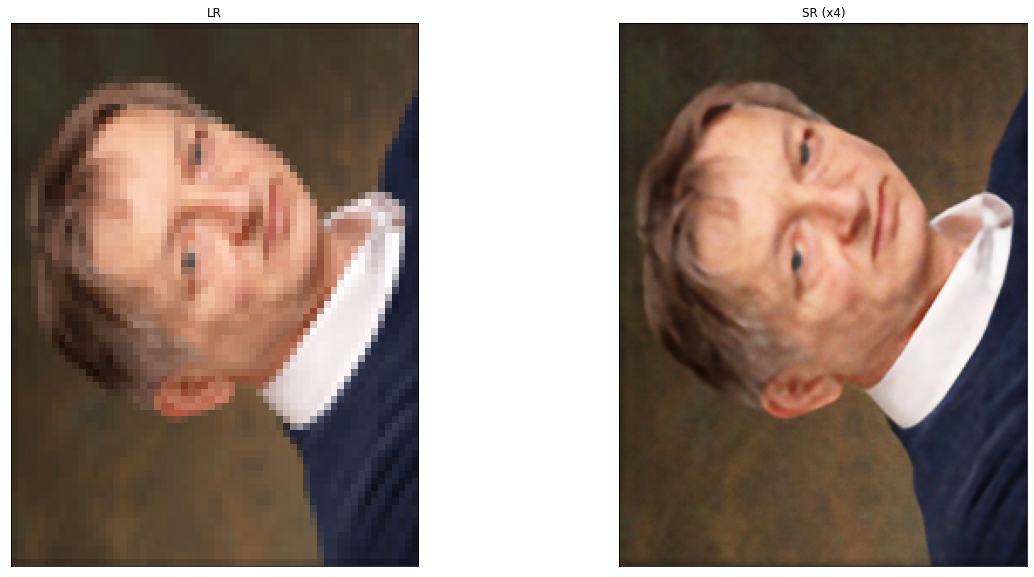

In [13]:
#
interpreter = tf.lite.Interpreter(model_path="bin/srgan_converted_int8.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on input data.
input_shape = input_details[0]['shape']
print(input_shape)
image = Image.open('./demo/0823x4-crop.jpeg')
image = image.resize(input_shape[1:3])

#arr = tf.convert_to_tensor(np.asarray(image, dtype='uint8'))
input_data = np.swapaxes(np.array(image), 0, 1)[None,...]

input_scale, input_zero_point = input_details[0]['quantization']
test_image_int = input_data / input_scale + input_zero_point
test_image_int=test_image_int.astype(input_details[0]['dtype'])

interpreter.set_tensor(input_details[0]['index'], test_image_int)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

scale, zero_point = output_details[0]['quantization']
output_data = output_data.astype(np.float32)
output_data = (output_data- zero_point)* scale

print(input_scale)
#print(output_data)
print(input_details[0]["quantization"])

print(output_data.shape)
plot_sample(input_data[0].astype('uint8'), output_data.astype('uint8')[0])

im = Image.fromarray(output_data.astype('uint8')[0])
im.save('./demo/img_sr_quant.png')

[ 1 80 60  3]
1.0
(1.0, 0)
(1, 320, 240, 3)


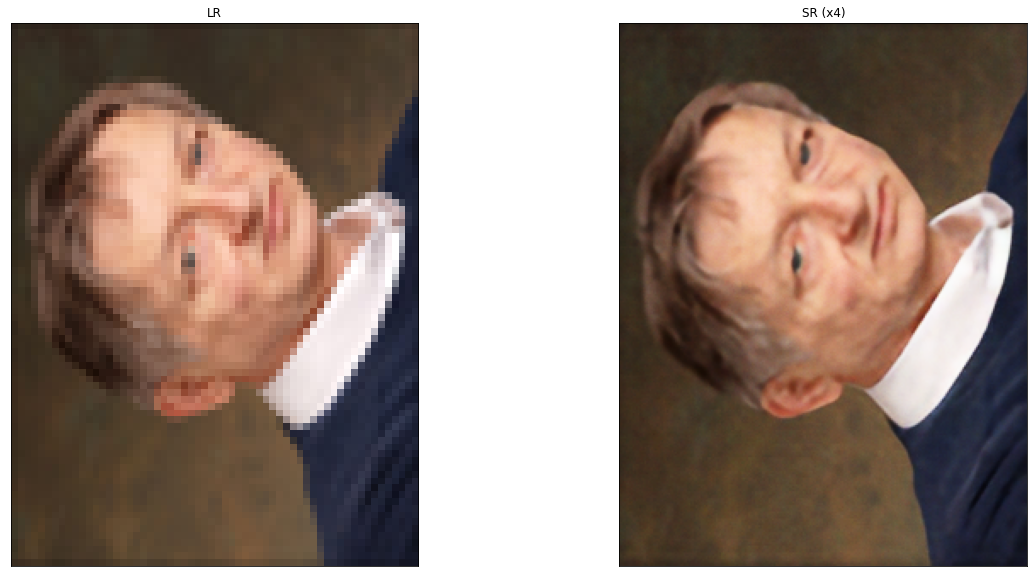

In [13]:
#
interpreter = tf.lite.Interpreter(model_path="bin/srgan_converted_int8.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on input data.
input_shape = input_details[0]['shape']
print(input_shape)
image = Image.open('./demo/0823x4-crop.jpeg')
image = image.resize(input_shape[1:3])

#arr = tf.convert_to_tensor(np.asarray(image, dtype='uint8'))
input_data = np.swapaxes(np.array(image), 0, 1)[None,...]

input_scale, input_zero_point = input_details[0]['quantization']
test_image_int = input_data / input_scale + input_zero_point
test_image_int=test_image_int.astype(input_details[0]['dtype'])

interpreter.set_tensor(input_details[0]['index'], test_image_int)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

scale, zero_point = output_details[0]['quantization']
output_data = output_data.astype(np.float32)
output_data = (output_data- zero_point)* scale

print(input_scale)
#print(output_data)
print(input_details[0]["quantization"])

print(output_data.shape)
plot_sample(input_data[0].astype('uint8'), output_data.astype('uint8')[0])

im = Image.fromarray(output_data.astype('uint8')[0])
im.save('./demo/img_sr_quant.png')

In [14]:
input_details

[{'name': 'input_1',
  'index': 78,
  'shape': array([ 1, 80, 60,  3], dtype=int32),
  'shape_signature': array([ 1, 80, 60,  3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (1.0, 0),
  'quantization_parameters': {'scales': array([1.], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

## Compile for EdgeTPU

In [15]:
!edgetpu_compiler bin/srgan_converted_int8.tflite -o ./bin/ -sad

Edge TPU Compiler version 16.0.384591198
Searching for valid delegate with step 1
Try to compile segment with 35 ops
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 256 ms.

Input model: bin/srgan_converted_int8.tflite
Input size: 701.55KiB
Output model: ./bin/srgan_converted_int8_edgetpu.tflite
Output size: 768.59KiB
On-chip memory used for caching model parameters: 665.75KiB
On-chip memory remaining for caching model parameters: 6.20MiB
Off-chip memory used for streaming uncached model parameters: 1.06KiB
Number of Edge TPU subgraphs: 1
Total number of operations: 35
Operation log: ./bin/srgan_converted_int8_edgetpu.log

Operator                       Count      Status

TANH                           1          Mapped to Edge TPU
CONV_2D                        18         Mapped to Edge TPU
TRANSPOSE_CONV                 2          Mapped to Edge TPU
QUANTIZE                       2          Mapped to Edge TPU
MUL                            1       

# Test TFLite float32

In [ ]:
import numpy as np
import tensorflow as tf
import time

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='bin/srgan.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
image = Image.open('./demo/0823x4-crop.jpeg')
image = image.resize(input_shape[1:3])
input_data = np.swapaxes(np.array(image, dtype=np.float32), 0, 1)[None,...]
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
print('----INFERENCE TIME----')
lat = []
for _ in range(100):
    start = time.perf_counter()
    interpreter.invoke()
    inference_time = time.perf_counter() - start
    lat.append(inference_time)
    print('%.1fms' % (inference_time * 1000))
_ = lat.pop()
print(f'Average Speed: {1/np.mean(np.array(lat))} fps')

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
#print(output_data)


----INFERENCE TIME----
300.9ms
273.9ms


# LR Scheduler

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import schedules
import matplotlib.pyplot as plt

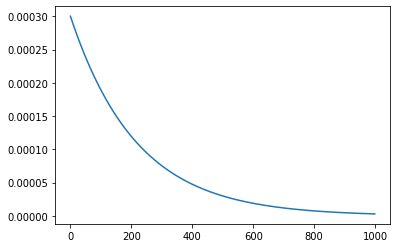

tf.Tensor(3.0138472e-06, shape=(), dtype=float32)


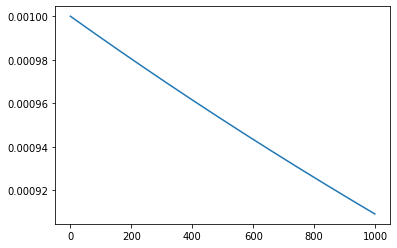

tf.Tensor(0.00090917357, shape=(), dtype=float32)


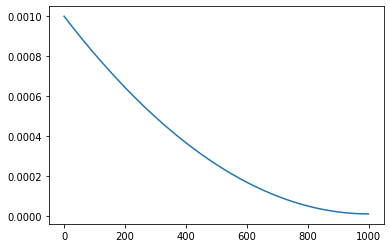

tf.Tensor(1.0000989e-05, shape=(), dtype=float32)


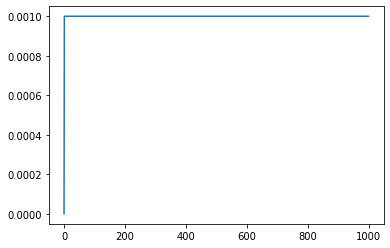

tf.Tensor(0.001, shape=(), dtype=float32)


In [8]:
N = 1000

scheds = [schedules.ExponentialDecay(3e-4, N, 0.01),
          schedules.InverseTimeDecay(1e-3, N, 0.1),
          schedules.PolynomialDecay(1e-3, N, 1e-5, power=2),
          schedules.PiecewiseConstantDecay([0],[1e-3,1e-3])
         ]

for sched in scheds:
    lr = []
    for i in range (N):
        lr.append(sched(i))
    plt.plot(lr)
    plt.show()
    print(lr[-1])

# Random Crop

In [3]:
import numpy as np
import tensorflow as tf
from pathlib import Path
from PIL import Image
    
from utils.srgan_tools import resolve_single
from utils.srgan import generator
from utils.tools import load_image, plot_sample

import numpy as np
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt 

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from utils.data import *

In [5]:
def random_crop(lr_img, hr_img, hr_crop_size=(96,128), scale=4):
    lr_crop_size = tuple(s // scale for s in hr_crop_size)
    lr_img_shape = tf.shape(lr_img)[:2]
    
    print(lr_crop_size)
    print(lr_img_shape)
    
    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size[1] + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size[0] + 1, dtype=tf.int32)

    print(lr_w.numpy(), lr_h.numpy())
    
    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size[0], lr_w:lr_w + lr_crop_size[1]]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size[0], hr_w:hr_w + hr_crop_size[1]]

    return lr_img_cropped, hr_img_cropped

In [ ]:
hr = Image.open('../../super_resolution/div2k/images/DIV2K_valid_LR_bicubic/X4/0898x4.png')
lr = hr.resize(tuple(dim // 4 for dim in hr.size))
display(hr, lr)
print(hr.size, lr.size)

plt.imshow(tf.io.decode_jpeg(tf.io.encode_jpeg(hr)))
plt.show()
plt.imshow(hr)
plt.show()
plt.imshow(hr - tf.io.decode_jpeg(tf.io.encode_jpeg(hr)))
plt.show()

In [ ]:
hr_t = tf.keras.preprocessing.image.img_to_array(hr)
lr_t = tf.keras.preprocessing.image.img_to_array(lr)

# [24 32  3] [ 96 128   3]

for i in range(100):
    crop_lr, crop_hr = random_crop(lr_t, hr_t)
    if (tf.shape(crop_lr).numpy()[0] != 24 or 
        tf.shape(crop_lr).numpy()[1] != 32 or 
        tf.shape(crop_hr).numpy()[0] != 96 or
        tf.shape(crop_hr).numpy()[1] != 128):
        print(tf.shape(crop_lr).numpy(), tf.shape(crop_hr).numpy())
        raise

In [ ]:
plt.imshow(crop_hr.astype('uint8'))
plt.show()
plt.imshow(crop_lr.astype('uint8')) 
plt.show()

In [6]:
a = DIV2K(scale=4, resolution=(160*4,120*4), downgrade='bicubic', subset='valid',
          images_dir='/home/simone/SR/sr-edge/dataset/div2k/images',
          caches_dir='/home/simone/SR/sr-edge/dataset/div2k/caches')

In [9]:
ds = a.dataset(random_transform=True, batch_size=16, repeat_count=1)

In [10]:
len(ds)

7

In [12]:
for i in ds.take(20):
    print(i[0].shape, i[1].shape)

(16, 160, 120, 3) (16, 640, 480, 3)
(16, 160, 120, 3) (16, 640, 480, 3)
(16, 160, 120, 3) (16, 640, 480, 3)
(16, 160, 120, 3) (16, 640, 480, 3)
(16, 160, 120, 3) (16, 640, 480, 3)
(16, 160, 120, 3) (16, 640, 480, 3)
(4, 160, 120, 3) (4, 640, 480, 3)


In [ ]:
for i in ds:
    print(i[0][0].shape)
    plt.imshow(i[0][0])
    break

# Shit

In [2]:
from utils.tools import read_yaml
import pprint

In [3]:
config = read_yaml('utils/config.yaml')

In [5]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

In [6]:
pp = pprint.PrettyPrinter(depth=1)

In [7]:
k = [config['MODE']]

In [8]:
pp.pprint(config[config['MODE']])

{'METRIC': 'NIQE',
 'LR': '1e-6',
 'SCHEDULER': 'Constant',
 'EXP_DECAY': 0.01,
 'LIN_DECAY': 0.1,
 'STEPS': 50000,
 'BATCH_SIZE': 16,
 'EVAL_EVERY': 2000,
 'TEACHER': 'None',
 'LAMBDA': 3.0,
 'TEMPERATURE': 0.1,
 'ALPHA': 10,
 'GP_WEIGHT': 100,
 'PERC_MODEL': 'VGG54',
 'DISC_OPT': 'RMSprop',
 'DISC_ACT': 'linear',
 'DISC_HEAD': 512}


In [9]:
pp.pformat(config[config['MODE']])

"{'METRIC': 'NIQE',\n 'LR': '1e-6',\n 'SCHEDULER': 'Constant',\n 'EXP_DECAY': 0.01,\n 'LIN_DECAY': 0.1,\n 'STEPS': 50000,\n 'BATCH_SIZE': 16,\n 'EVAL_EVERY': 2000,\n 'TEACHER': 'None',\n 'LAMBDA': 3.0,\n 'TEMPERATURE': 0.1,\n 'ALPHA': 10,\n 'GP_WEIGHT': 100,\n 'PERC_MODEL': 'VGG54',\n 'DISC_OPT': 'RMSprop',\n 'DISC_ACT': 'linear',\n 'DISC_HEAD': 512}"

In [10]:
type(config[config['MODE']]['BATCH_SIZE'])

int

In [11]:
tuple(config['PATCH_SIZE'])

(96, 96)

In [12]:
float(config[config['MODE']]['LR'])

1e-06

In [19]:
from utils.srgan import generator
import tensorflow as tf
d = generator(num_filters=32, num_res_blocks=4, shape=(96,96,3))

In [20]:
d.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 96, 96, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 96, 96, 32)   7808        lambda_6[0][0]                   
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 96, 96, 32)   0           conv2d_62[0][0]                  
____________________________________________________________________________________________

In [21]:
o, f = d(np.random.rand(16,96,96,3))

In [22]:
f.shape

TensorShape([5, 16, 96, 96, 32])

In [23]:
ff = tf.gather(f,[1,2,4])

In [24]:
ff.shape

TensorShape([3, 16, 96, 96, 32])

In [12]:
def should_save(m):
    if not 'best_metr' in globals():
        return True
    elif m > best_metr:
        return 'PSNR' == 'PSNR'
    else:
        return 'PSNR' == 'NIQE'

In [17]:
should_save(11)

True

In [14]:
best_metr = 10